# Triton Impl

In [ ]:
import torch
import triton
import triton.language as tl

@triton.jit
def _attn_fwd_inner(
    O_block,
    l_i,
    m_i,
    Q_block,
    K_block_ptr,
    V_block_ptr,
    block_index_q,
    softmax_scale,
    BLOCK_SIZE_Q: tl.constexpr,
    BLOCK_SIZE_KV: tl.constexpr,
    STAGE: tl.constexpr,
    offs_q: tl.constexpr,
    offs_kv: tl.constexpr,
    SEQ_LEN: tl.constexpr,
):
    # range of values handled by this stage
    if STAGE == 1:
        # From 0 to the left of the diagonal
        lo, hi = 0, block_index_q * BLOCK_SIZE_Q
    elif STAGE == 2:
        # Used only for the block in which there is transition between non-masked and masked keys
        lo, hi = block_index_q * BLOCK_SIZE_Q, (block_index_q + 1) * BLOCK_SIZE_Q
        lo = tl.multiple_of(lo, BLOCK_SIZE_Q)
    else:
        # Only used for non-causal attention
        lo, hi = 0, SEQ_LEN

    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))

    # loop over k, v and update accumulator
    for start_kv in range(lo, hi, BLOCK_SIZE_KV):
        # Just let the compiler know that start_n is a multiple of BLOCK_N, so the compiler can do optimizations
        start_kv = tl.multiple_of(start_kv, BLOCK_SIZE_KV)

        # -- compute qk ----
        K_block = tl.load(K_block_ptr)
        QK_block = tl.dot(Q_block, K_block)

        if STAGE == 2:
            mask = offs_q[:, None] >= (start_kv + offs_kv[None, :])
            QK_block = QK_block * softmax_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(QK_block, 1))
            QK_block -= m_ij[:, None]
        else:
            # Compute the maximum value of qk or keep the old max value
            m_ij = tl.maximum(m_i, tl.max(QK_block, 1) * softmax_scale)
            QK_block = QK_block * softmax_scale - m_ij[:, None]

        # Compute the exponential of each dot product, so now we are computing exp(qk_ij - m_ij)
        P_block = tl.math.exp(QK_block)
        # Compute the sum by rows of the attention scores
        l_ij = tl.sum(P_block, 1)

        # This is the correction factor for the previous l_i
        alpha = tl.math.exp(m_i - m_ij)
        # Apply the correction factor to the previous l_i and add the new l_ij
        l_i = l_i * alpha + l_ij

        V_block = tl.load(V_block_ptr)
        P_block = P_block.to(tl.float16)
        # This computes the following: O_new = P x V + O_old * alpha
        O_block = O_block * alpha[:, None]
        O_block = tl.dot(P_block, V_block, O_block)

        m_i = m_ij

        # Move to the next block of K and V
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_SIZE_KV, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_SIZE_KV))
    return O_block, l_i, m_i


@triton.autotune(
    [
        triton.Config(
            {"BLOCK_SIZE_Q": BLOCK_SIZE_Q, "BLOCK_SIZE_KV": BLOCK_SIZE_KV},
            num_stages=num_stages,
            num_warps=num_warps,
        )
        for BLOCK_SIZE_Q in [64, 128]
        for BLOCK_SIZE_KV in [32, 64]
        for num_stages in ([3, 4, 7])
        for num_warps in [2, 4]
    ],
    key=["SEQ_LEN", "HEAD_DIM"],
)
@triton.jit
def _attn_fwd(
    Q,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    K,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    V,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    softmax_scale,
    M,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN
    O,  # BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM
    stride_Q_batch,
    stride_Q_head,
    stride_Q_seq,
    stride_Q_dim,
    stride_K_batch,
    stride_K_head,
    stride_K_seq,
    stride_K_dim,
    stride_V_batch,
    stride_V_head,
    stride_V_seq,
    stride_V_dim,
    stride_O_batch,
    stride_O_head,
    stride_O_seq,
    stride_O_dim,
    BATCH_SIZE,
    NUM_HEADS: tl.constexpr,
    SEQ_LEN: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    BLOCK_SIZE_Q: tl.constexpr,
    BLOCK_SIZE_KV: tl.constexpr,
    STAGE: tl.constexpr,
):
    tl.static_assert(BLOCK_SIZE_KV <= HEAD_DIM)

    # This indicate which block in the sequence length to process
    block_index_q = tl.program_id(0)

    # This indicates which head and batch to process. Each program is associated with a single head of a single batch
    index_batch_head = tl.program_id(1)
    # This indicate which batch this program is associated with (each batch has NUM_HEADS heads)
    index_batch = index_batch_head // NUM_HEADS
    # This indicate the position of the head in the batch
    index_head = index_batch_head % NUM_HEADS

    # This allows to get the (N_CTX, HEAD_DIM) block in the Q, K, V by selecting indexing it by batch and head
    qvk_offset = (
        index_batch.to(tl.int64) * stride_Q_batch
        + index_head.to(tl.int64) * stride_Q_head
    )

    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_Q_seq, stride_Q_dim),
        offsets=(block_index_q * BLOCK_SIZE_Q, 0),
        block_shape=(BLOCK_SIZE_Q, HEAD_DIM),
        order=(1, 0),
    )

    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_V_seq, stride_V_dim),
        offsets=(0, 0),
        block_shape=(BLOCK_SIZE_KV, HEAD_DIM),
        order=(1, 0),
    )

    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(HEAD_DIM, SEQ_LEN),
        strides=(
            stride_K_dim,
            stride_K_seq,
        ),  # We invert the strides w.r.t Q, so we transpose the matrix
        offsets=(0, 0),
        block_shape=(HEAD_DIM, BLOCK_SIZE_KV),
        order=(0, 1),
    )

    O_block_ptr = tl.make_block_ptr(
        base=O + qvk_offset,
        shape=(SEQ_LEN, HEAD_DIM),
        strides=(stride_O_seq, stride_O_dim),
        offsets=(block_index_q * BLOCK_SIZE_Q, 0),
        block_shape=(BLOCK_SIZE_Q, HEAD_DIM),
        order=(1, 0),
    )

    # offs_q: the offsets for the tokens in the Q to process
    offs_q = block_index_q * BLOCK_SIZE_Q + tl.arange(0, BLOCK_SIZE_Q)
    # offs_kv: the offsets for the tokens in the K and V sequence to process
    offs_kv = tl.arange(0, BLOCK_SIZE_KV)

    # m_i: the running maximum. We have one for each query
    m_i = tl.zeros([BLOCK_SIZE_Q], dtype=tl.float32) - float("inf")
    # l_i: the running sum. We have one for each query (as we sum the attention scores by rows)
    l_i = tl.zeros([BLOCK_SIZE_Q], dtype=tl.float32) + 1.0
    # acc: the accumulator for the output, which is a group of rows of the O matrix
    O_block = tl.zeros([BLOCK_SIZE_Q, HEAD_DIM], dtype=tl.float32)

    # load the blocks of Q: it will stay in SRAM throughout
    Q_block = tl.load(Q_block_ptr)

    # Stage: 3 if causal, else 1

    if STAGE == 1 or STAGE == 3:
        # This step runs for non-causal attention or for the blocks to the left of the diagonal in the causal attention
        O_block, l_i, m_i = _attn_fwd_inner(
            O_block,
            l_i,
            m_i,
            Q_block,
            K_block_ptr,
            V_block_ptr,
            block_index_q,
            softmax_scale,
            BLOCK_SIZE_Q,
            BLOCK_SIZE_KV,
            4 - STAGE,
            offs_q,
            offs_kv,
            SEQ_LEN,
        )

    if STAGE == 3:
        # This step runs for the blocks to the right of the diagonal in the causal attention
        O_block, l_i, m_i = _attn_fwd_inner(
            O_block,
            l_i,
            m_i,
            Q_block,
            K_block_ptr,
            V_block_ptr,
            block_index_q,
            softmax_scale,
            BLOCK_SIZE_Q,
            BLOCK_SIZE_KV,
            2,
            offs_q,
            offs_kv,
            SEQ_LEN,
        )
    # epilogue
    m_i += tl.math.log(
        l_i
    )  # This is needed to compute the logsumexp for the backwards pass
    O_block = O_block / l_i[:, None]
    m_ptrs = M + index_batch_head * SEQ_LEN + offs_q
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, O_block.to(O.type.element_ty))


@triton.jit
def _attn_bwd_preprocess(
    O,
    dO,
    D,
    SEQ_LEN,
    BLOCK_SIZE_Q: tl.constexpr,
    HEAD_DIM: tl.constexpr,
):
    block_index_q = tl.program_id(0)
    offs_q = block_index_q * BLOCK_SIZE_Q + tl.arange(0, BLOCK_SIZE_Q)
    index_batch_head = tl.program_id(1)
    offs_dim = tl.arange(0, HEAD_DIM)
    # Load a single block of BLOCK_SIZE_Q rows of O
    O_block = tl.load(
        O
        + index_batch_head * HEAD_DIM * SEQ_LEN
        + offs_q[:, None] * HEAD_DIM
        + offs_dim[None, :]
    )
    # Load a single block of BLOCK_SIZE_Q rows of dO
    dO_block = tl.load(
        dO
        + index_batch_head * HEAD_DIM * SEQ_LEN
        + offs_q[:, None] * HEAD_DIM
        + offs_dim[None, :]
    ).to(tl.float32)
    # Compute the D block
    D_block = tl.sum(dO_block * O_block, axis=1)  # Shape: (BLOCK_SIZE_Q,)
    # Store the D block
    D_block_ptrs = D + index_batch_head * SEQ_LEN + offs_q
    tl.store(D_block_ptrs, D_block)


@triton.jit
def _attn_bwd_dq(
    Q,
    K,
    V,
    softmax_scale,
    dO,
    dQ,
    dK,
    dV,
    M,
    D,
    stride_batch,
    stride_head,
    stride_seq,
    stride_dim,
    NUM_HEADS,
    SEQ_LEN,
    BLOCK_Q: tl.constexpr,
    BLOCK_KV: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    STAGE: tl.constexpr,
):
    index_batch_head = tl.program_id(2)
    index_batch = index_batch_head // NUM_HEADS
    index_head = index_batch_head % NUM_HEADS
    offset_batch_head = (stride_batch * index_batch + stride_head * index_head).to(
        tl.int64
    )
    # This is the offset that allows us to select the right sequence given the batch and head.
    offset_batch_head_seq = (index_batch_head * SEQ_LEN).to(tl.int64)

    # Make sure the pointers are in the right place w.r.t batch and head
    # The reason we don't access the blocks through make_block_ptr is because we need to use the range of offsets to apply the masking
    Q += offset_batch_head
    K += offset_batch_head
    V += offset_batch_head
    dO += offset_batch_head
    dQ += offset_batch_head
    dK += offset_batch_head
    dV += offset_batch_head

    # Make sure the pointers are in the right place w.r.t batch, head and sequence
    M += offset_batch_head_seq
    D += offset_batch_head_seq

    # load scales
    offs_dim = tl.arange(0, HEAD_DIM)

    index_block_kv = tl.program_id(0)

    start_q = index_block_kv * BLOCK_Q
    offs_q = start_q + tl.arange(0, BLOCK_Q)

    Q_block = tl.load(Q + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim)
    dQ_block = tl.zeros([BLOCK_Q, HEAD_DIM], dtype=tl.float32)
    dO_block = tl.load(
        dO + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )

    M_block = tl.load(M + offs_q)
    M_block = M_block[:, None]

    offs_kv = tl.arange(0, BLOCK_KV)

    # We access the K and V as transposed blocks
    kT_ptrs = K + offs_kv[None, :] * stride_seq + offs_dim[:, None] * stride_dim
    vT_ptrs = V + offs_kv[None, :] * stride_seq + offs_dim[:, None] * stride_dim

    Di = tl.load(D + offs_q)

    curr_kv = 0
    num_steps = SEQ_LEN // BLOCK_KV
    for blk_idx in range(num_steps):
        K_T_block = tl.load(kT_ptrs)
        V_T_block = tl.load(vT_ptrs)
        QK_block = softmax_scale * tl.dot(Q_block, K_T_block)
        P_block = tl.math.exp(QK_block - M_block)

        if STAGE == 3:
            # Autoregressive masking.
            offs_kv = curr_kv + tl.arange(0, BLOCK_KV)
            mask_block = offs_q[:, None] >= offs_kv[None, :]
            P_block = tl.where(mask_block, P_block, 0.0)

        # Compute dP and dS.
        dP_block = tl.dot(dO_block, V_T_block).to(tl.float32)
        dS_block = P_block * (dP_block - Di[:, None])
        dS_block = dS_block.to(tl.float16)
        # Compute dQ.
        # NOTE: We need to de-scale dq in the end, because kT was pre-scaled.
        dQ_block += softmax_scale * tl.dot(dS_block, tl.trans(K_T_block))
        # Increment pointers.
        curr_kv += BLOCK_KV
        kT_ptrs += BLOCK_KV * stride_seq
        vT_ptrs += BLOCK_KV * stride_seq

    dQ_block_ptrs = dQ + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dQ_block_ptrs, dQ_block)


@triton.jit
def _attn_bwd_dk_dv(
    Q,
    K,
    V,
    softmax_scale,
    dO,
    dQ,
    dK,
    dV,
    M,
    D,
    stride_batch,
    stride_head,
    stride_seq,
    stride_dim,
    NUM_HEADS,
    SEQ_LEN,
    BLOCK_Q: tl.constexpr,
    BLOCK_KV: tl.constexpr,
    HEAD_DIM: tl.constexpr,
    STAGE: tl.constexpr,
):
    index_batch_head = tl.program_id(2)
    index_batch = index_batch_head // NUM_HEADS
    index_head = index_batch_head % NUM_HEADS
    offset_batch_head = (stride_batch * index_batch + stride_head * index_head).to( # Enters the right batch and right head
        tl.int64
    )
    # This is the offset that allows us to select the right sequence given the batch and head.
    offset_batch_head_seq = (index_batch_head * SEQ_LEN).to(tl.int64)

    # Make sure the pointers are in the right place w.r.t batch and head
    # The reason we don't access the blocks through make_block_ptr is because we need to use the range of offsets to apply the masking
    Q += offset_batch_head
    K += offset_batch_head
    V += offset_batch_head
    dO += offset_batch_head
    dQ += offset_batch_head
    dK += offset_batch_head
    dV += offset_batch_head

    # Make sure the pointers are in the right place w.r.t batch, head and sequence
    M += offset_batch_head_seq
    D += offset_batch_head_seq

    # load scales
    offs_dim = tl.arange(0, HEAD_DIM)

    index_block_kv = tl.program_id(0)
    start_kv = index_block_kv * BLOCK_KV

    offs_kv = start_kv + tl.arange(0, BLOCK_KV)

    dV_block = tl.zeros([BLOCK_KV, HEAD_DIM], dtype=tl.float32)
    dK_block = tl.zeros([BLOCK_KV, HEAD_DIM], dtype=tl.float32)

    # load K and V: they stay in SRAM throughout the inner loop.
    K_block = tl.load(
        K + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )  # Shape: (BLOCK_KV1, HEAD_DIM)
    V_block = tl.load(
        V + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    )  # Shape: (BLOCK_KV1, HEAD_DIM)

    offs_q = tl.arange(0, BLOCK_Q)

    # We access the Q as a transposed array, so that's why we treat offs_q as a column vector ans offs_dim as a row vector
    # This is equivalent to doing:
    # q_ptrs = Q + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    # qT_ptrs = tl.trans(q_ptrs)
    # We point to the first BLOCK_Q rows of Q for both the qT and dO pointers, inside the for loop we will move forward by BLOCK_Q rows at each iteration.
    qT_ptrs = Q + offs_q[None, :] * stride_seq + offs_dim[:, None] * stride_dim
    dO_ptrs = dO + offs_q[:, None] * stride_seq + offs_dim[None, :] * stride_dim

    # Iterates over the sequence dimension of the query
    curr_q = 0
    num_steps = SEQ_LEN // BLOCK_Q
    for blk_idx in range(num_steps):
        # Load a block of Q
        qT_block = tl.load(qT_ptrs)
        # Load the logsumexp values for the queries in the current block
        offs_q = curr_q + tl.arange(0, BLOCK_Q)
        m = tl.load(M + offs_q)

        # This gives us (QK^T)^T = (K^T)^T(Q^T) = K(Q^T) = P^T
        QK_T_block = softmax_scale * tl.dot(K_block, qT_block)
        # We apply the softmax by using the logsumexp trick
        P_T_block = tl.math.exp(QK_T_block - m[None, :])

        if STAGE == 3:
            # Autoregressive masking.
            # mask is True for all values that DO NOT NEED TO BE MASKED
            mask_block = (
                offs_q[None, :] >= offs_kv[:, None]
            )  # Shape: (BLOCK_KV1, BLOCK_Q1)
            # Replace all the masked values with 0.
            # In this case we do not need to mask with -Inf before applying the softmax since we already computed the normalization factors (stored in "m")
            P_T_block = tl.where(mask_block, P_T_block, 0.0)

        dO_block = tl.load(dO_ptrs)
        # According to the formula: dV_new = dV_old + P^T x dO, where x is the matrix multiplication
        dV_block += tl.dot(P_T_block.to(tl.float16), dO_block)

        # Delta = rowsum(O * dO) where * is the element-wise product
        Di = tl.load(D + offs_q)

        # dP = dO x V^T, so dP^T = V x dO^T
        # Where x is the matrix multiplication
        dpT_block = tl.dot(V_block, tl.trans(dO_block)).to(tl.float32)

        # We know that dS = P * (dP - Delta), so dS^T = P^T * (dP^T - Delta^T)

        dS_T_block = P_T_block * (dpT_block - Di[None, :])
        dS_T_block = dS_T_block.to(tl.float16)

        # According to the formula on the paper: dK_new = dK_old + dS^T x Q
        dK_block += softmax_scale * tl.dot(dS_T_block, tl.trans(qT_block))
        # Increment pointers.
        curr_q += BLOCK_Q
        qT_ptrs += BLOCK_Q * stride_seq
        dO_ptrs += BLOCK_Q * stride_seq

    # Write back dV.
    dV_block_ptrs = dV + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dV_block_ptrs, dV_block)

    # Write back dK.
    dK_block_ptrs = dK + offs_kv[:, None] * stride_seq + offs_dim[None, :] * stride_dim
    tl.store(dK_block_ptrs, dK_block)


class TritonAttention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, Q, K, V, causal, softmax_scale):
        HEAD_DIM_Q, HEAD_DIM_K = Q.shape[-1], K.shape[-1]
        HEAD_DIM_V = V.shape[-1]

        BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM = Q.shape

        assert HEAD_DIM_Q == HEAD_DIM_K and HEAD_DIM_K == HEAD_DIM_V

        O = torch.empty_like(Q)
        stage = 3 if causal else 1

        grid = lambda args: (
            triton.cdiv(SEQ_LEN, args["BLOCK_SIZE_Q"]),
            BATCH_SIZE * NUM_HEADS,
            1,
        )

        # M is the logsumexp for the backward pass, one for each query
        M = torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN), device=Q.device, dtype=torch.float32
        )

        _attn_fwd[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=softmax_scale,
            M=M,
            O=O,
            stride_Q_batch=Q.stride(0),
            stride_Q_head=Q.stride(1),
            stride_Q_seq=Q.stride(2),
            stride_Q_dim=Q.stride(3),
            stride_K_batch=K.stride(0),
            stride_K_head=K.stride(1),
            stride_K_seq=K.stride(2),
            stride_K_dim=K.stride(3),
            stride_V_batch=V.stride(0),
            stride_V_head=V.stride(1),
            stride_V_seq=V.stride(2),
            stride_V_dim=V.stride(3),
            stride_O_batch=O.stride(0),
            stride_O_head=O.stride(1),
            stride_O_seq=O.stride(2),
            stride_O_dim=O.stride(3),
            BATCH_SIZE=Q.shape[0],
            NUM_HEADS=Q.shape[1],
            SEQ_LEN=Q.shape[2],
            HEAD_DIM=HEAD_DIM_K,
            STAGE=stage,
        )

        ctx.save_for_backward(Q, K, V, O, M)
        ctx.grid = grid
        ctx.softmax_scale = softmax_scale
        ctx.HEAD_DIM = HEAD_DIM_K
        ctx.causal = causal
        return O

    @staticmethod
    def backward(ctx, dO):
        Q, K, V, O, M = ctx.saved_tensors

        assert dO.is_contiguous()
        assert Q.stride() == K.stride() == V.stride() == O.stride() == dO.stride()
        dQ = torch.empty_like(Q)
        dK = torch.empty_like(K)
        dV = torch.empty_like(V)

        BATCH_SIZE, NUM_HEADS, SEQ_LEN = Q.shape[:3]
        NUM_WARPS, NUM_STAGES = 4, 3
        BLOCK_SIZE_MICRO, BLOCK_SIZE_MACRO = 32, 128

        preprocess_grid = (SEQ_LEN // BLOCK_SIZE_MACRO, BATCH_SIZE * NUM_HEADS)
        D = torch.empty_like(M)  # Shape: (BATCH_SIZE, NUM_HEADS, SEQ_LEN)

        # Compute all the elements Di
        _attn_bwd_preprocess[preprocess_grid](
            O=O,
            dO=dO,
            D=D,
            SEQ_LEN=SEQ_LEN,
            BLOCK_SIZE_Q=BLOCK_SIZE_MACRO,
            HEAD_DIM=ctx.HEAD_DIM,
        )

        grid = (SEQ_LEN // BLOCK_SIZE_MACRO, 1, BATCH_SIZE * NUM_HEADS)

        stage = 3 if ctx.causal else 1

        # Fix KV and it erate through all the Q blocks
        _attn_bwd_dk_dv[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=ctx.softmax_scale,
            dO=dO,
            dQ=dQ,
            dK=dK,
            dV=dV,
            M=M,
            D=D,
            stride_batch=Q.stride(0),
            stride_head=Q.stride(1),
            stride_seq=Q.stride(2),
            stride_dim=Q.stride(3),
            NUM_HEADS=NUM_HEADS,
            SEQ_LEN=SEQ_LEN,
            BLOCK_Q=BLOCK_SIZE_MICRO,
            BLOCK_KV=BLOCK_SIZE_MACRO,
            HEAD_DIM=ctx.HEAD_DIM,
            STAGE=stage,
            num_warps=NUM_WARPS,
            num_stages=NUM_STAGES,
        )

        # Fix Q and iterate through all the KV block
        _attn_bwd_dq[grid](
            Q=Q,
            K=K,
            V=V,
            softmax_scale=ctx.softmax_scale,
            dO=dO,
            dQ=dQ,
            dK=dK,
            dV=dV,
            M=M,
            D=D,
            stride_batch=Q.stride(0),
            stride_head=Q.stride(1),
            stride_seq=Q.stride(2),
            stride_dim=Q.stride(3),
            NUM_HEADS=NUM_HEADS,
            SEQ_LEN=SEQ_LEN,
            BLOCK_Q=BLOCK_SIZE_MACRO,
            BLOCK_KV=BLOCK_SIZE_MICRO,
            HEAD_DIM=ctx.HEAD_DIM,
            STAGE=stage,
            num_warps=NUM_WARPS,
            num_stages=NUM_STAGES,
        )

        return dQ, dK, dV, None, None


def test_op(BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM, causal, dtype=torch.float16):
    # Initialize inputs
    Q = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )
    K = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )
    V = (
        torch.empty(
            (BATCH_SIZE, NUM_HEADS, SEQ_LEN, HEAD_DIM), dtype=dtype, device="cuda"
        )
        .normal_(mean=0.0, std=0.5)
        .requires_grad_()
    )

    softmax_scale = 1 / (HEAD_DIM**0.5)
    dO = torch.randn_like(Q)

    # PyTorch reference implementation timing
    torch.cuda.synchronize()
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)

    start_time.record()

    MASK = torch.tril(torch.ones((SEQ_LEN, SEQ_LEN), device="cuda"))
    P = torch.matmul(Q, K.transpose(2, 3)) * softmax_scale
    if causal:
        P[:, :, MASK == 0] = float("-inf")
    P = torch.softmax(P.float(), dim=-1).half()
    ref_O = torch.matmul(P, V)
    ref_O.backward(dO)
    ref_dV, V.grad = V.grad.clone(), None
    ref_dK, K.grad = K.grad.clone(), None
    ref_dQ, Q.grad = Q.grad.clone(), None

    end_time.record()
    torch.cuda.synchronize()
    pytorch_time = start_time.elapsed_time(end_time)

    # Triton implementation timing
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)

    start_time.record()

    tri_out = TritonAttention.apply(Q, K, V, causal, softmax_scale).half()
    tri_out.backward(dO)
    tri_dV, V.grad = V.grad.clone(), None
    tri_dK, K.grad = K.grad.clone(), None
    tri_dQ, Q.grad = Q.grad.clone(), None

    end_time.record()
    torch.cuda.synchronize()
    triton_time = start_time.elapsed_time(end_time)

    # Calculate accuracy metrics
    output_diff = torch.abs(ref_O - tri_out).mean()
    dQ_diff = torch.abs(ref_dQ - tri_dQ).mean()
    dK_diff = torch.abs(ref_dK - tri_dK).mean()
    dV_diff = torch.abs(ref_dV - tri_dV).mean()

    print(f"\nTest Configuration:")
    print(f"Batch Size: {BATCH_SIZE}, Num Heads: {NUM_HEADS}, Seq Length: {SEQ_LEN}, Head Dim: {HEAD_DIM}")
    print(f"Causal: {causal}")

    print(f"\nTiming Comparison:")
    print(f"PyTorch Time: {pytorch_time:.2f} ms")
    print(f"Triton Time: {triton_time:.2f} ms")
    print(f"Speedup: {pytorch_time/triton_time:.2f}x")

    print(f"\nAccuracy Comparison (Mean Absolute Difference):")
    print(f"Output Difference: {output_diff:.6f}")
    print(f"dQ Difference: {dQ_diff:.6f}")
    print(f"dK Difference: {dK_diff:.6f}")
    print(f"dV Difference: {dV_diff:.6f}")

    # Original assertions for correctness
    rtol = 0.0
    atol = 1e-2
    assert torch.allclose(ref_O, tri_out, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dK, tri_dK, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dV, tri_dV, atol=atol, rtol=rtol)
    assert torch.allclose(ref_dQ, tri_dQ, atol=atol, rtol=rtol)

# PyTorch Naive Impl

In [ ]:
import torch
import torch.nn as nn
import math

class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

# Benchmark

Seq Len   64 | PyTorch: 0.92 ms, 14720.44 MB | Triton: 0.57 ms, 14723.63 MB
Seq Len  128 | PyTorch: 0.93 ms, 14783.45 MB | Triton: 0.63 ms, 14756.81 MB
Seq Len  256 | PyTorch: 1.63 ms, 14972.50 MB | Triton: 0.75 ms, 14823.19 MB
Seq Len  512 | PyTorch: 4.87 ms, 15638.69 MB | Triton: 1.29 ms, 14955.94 MB
Seq Len 1024 | PyTorch: 18.50 ms, 18123.44 MB | Triton: 3.56 ms, 15221.94 MB
Seq Len 2048 | PyTorch: 82.72 ms, 27702.44 MB | Triton: 12.59 ms, 15752.44 MB


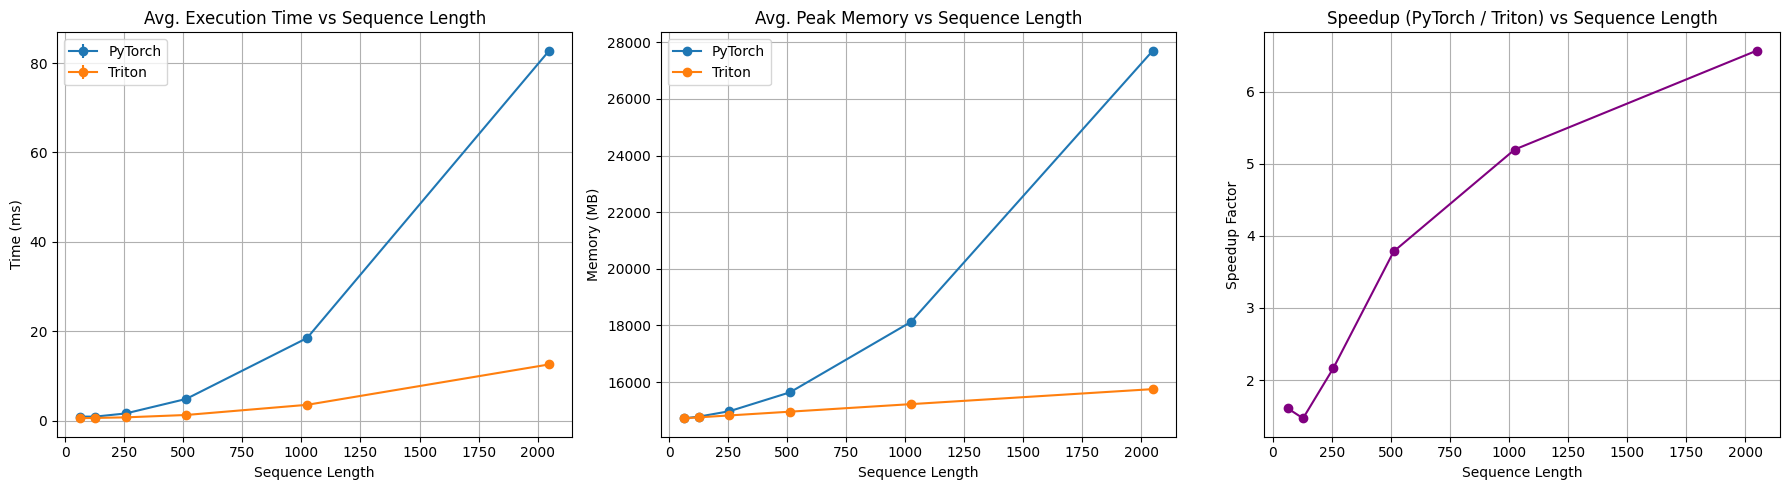

In [ ]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

# ----------------------------
# PyTorch Native Flash Attention
# ----------------------------
def torch_flash_attention(Q, K, V, causal, softmax_scale):
    scores = torch.matmul(Q, K.transpose(-2, -1)) * softmax_scale
    if causal:
        # Create a lower-triangular mask for causal attention.
        mask = torch.tril(torch.ones(scores.shape[-2:], device=scores.device)).bool()
        scores = scores.masked_fill(~mask, float('-inf'))
    attn = torch.softmax(scores, dim=-1)
    return torch.matmul(attn, V)

# ----------------------------
# Benchmarking Helper Function
# ----------------------------
def benchmark_function(fn, Q, K, V, causal, softmax_scale, n_iters=50, warmup=10):
    """
    Runs warmup iterations then measures average forward+backward time and peak memory usage.
    Uses a contiguous gradient tensor to satisfy TritonAttention.backward().

    Returns:
      mean_time   : average elapsed time per iteration (ms)
      std_time    : standard deviation of elapsed times (ms)
      mean_memory : average peak memory usage (bytes)
    """
    # Warmup phase.
    for _ in range(warmup):
        out = fn(Q, K, V, causal, softmax_scale)
        grad = torch.ones_like(out).contiguous()
        out.backward(grad)
        torch.cuda.synchronize()
        Q.grad = None
        K.grad = None
        V.grad = None

    times = []
    mems = []
    for _ in range(n_iters):
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
        start_evt = torch.cuda.Event(enable_timing=True)
        end_evt = torch.cuda.Event(enable_timing=True)
        start_evt.record()

        out = fn(Q, K, V, causal, softmax_scale)
        grad = torch.ones_like(out).contiguous()
        out.backward(grad)

        end_evt.record()
        torch.cuda.synchronize()
        times.append(start_evt.elapsed_time(end_evt))
        mems.append(torch.cuda.max_memory_allocated())
        Q.grad = None
        K.grad = None
        V.grad = None

    return np.mean(times), np.std(times), np.mean(mems)

# ----------------------------
# Parameter Sweep & Plotting
# ----------------------------
def run_benchmarks():
    device = torch.device("cuda")

    # Fixed parameters.
    BATCH_SIZE = 32
    NUM_HEADS  = 12
    HEAD_DIM   = 64
    causal     = True
    dtype      = torch.float16
    softmax_scale = 1.0 / math.sqrt(HEAD_DIM)

    # Parameter sweep: vary sequence lengths.
    seq_lens = [64, 128, 256, 512, 1024, 2048]

    # Containers for metrics.
    torch_times = []
    torch_std   = []
    torch_mems  = []

    triton_times = []
    triton_std   = []
    triton_mems  = []

    for seq_len in seq_lens:
        # Create random inputs.
        Q = torch.randn(BATCH_SIZE, NUM_HEADS, seq_len, HEAD_DIM, device=device, dtype=dtype, requires_grad=True)
        K = torch.randn(BATCH_SIZE, NUM_HEADS, seq_len, HEAD_DIM, device=device, dtype=dtype, requires_grad=True)
        V = torch.randn(BATCH_SIZE, NUM_HEADS, seq_len, HEAD_DIM, device=device, dtype=dtype, requires_grad=True)

        # Benchmark native PyTorch implementation.
        t_mean, t_std, t_mem = benchmark_function(torch_flash_attention, Q, K, V, causal, softmax_scale)
        torch_times.append(t_mean)
        torch_std.append(t_std)
        torch_mems.append(t_mem)

        # Clone inputs for Triton (to avoid gradient interference).
        Q2 = Q.detach().clone().requires_grad_()
        K2 = K.detach().clone().requires_grad_()
        V2 = V.detach().clone().requires_grad_()

        # Benchmark Triton implementation.
        # TritonAttention.apply must be defined in your Triton code.
        def triton_fn(Q, K, V, causal, softmax_scale):
            return TritonAttention.apply(Q, K, V, causal, softmax_scale)

        tri_mean, tri_std, tri_mem = benchmark_function(triton_fn, Q2, K2, V2, causal, softmax_scale)
        triton_times.append(tri_mean)
        triton_std.append(tri_std)
        triton_mems.append(tri_mem)

        print(f"Seq Len {seq_len:4d} | PyTorch: {t_mean:.2f} ms, {t_mem/1024**2:.2f} MB | "
              f"Triton: {tri_mean:.2f} ms, {tri_mem/1024**2:.2f} MB")

    # Compute speedup factor.
    speedup = np.array(torch_times) / np.array(triton_times)

    # Plotting.
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot average time vs sequence length.
    axs[0].errorbar(seq_lens, torch_times, yerr=torch_std, fmt='-o', label='PyTorch')
    axs[0].errorbar(seq_lens, triton_times, yerr=triton_std, fmt='-o', label='Triton')
    axs[0].set_title("Avg. Execution Time vs Sequence Length")
    axs[0].set_xlabel("Sequence Length")
    axs[0].set_ylabel("Time (ms)")
    axs[0].legend()
    axs[0].grid(True)

    # Plot memory usage vs sequence length.
    axs[1].plot(seq_lens, np.array(torch_mems)/1024**2, '-o', label='PyTorch')
    axs[1].plot(seq_lens, np.array(triton_mems)/1024**2, '-o', label='Triton')
    axs[1].set_title("Avg. Peak Memory vs Sequence Length")
    axs[1].set_xlabel("Sequence Length")
    axs[1].set_ylabel("Memory (MB)")
    axs[1].legend()
    axs[1].grid(True)

    # Plot speedup vs sequence length.
    axs[2].plot(seq_lens, speedup, '-o', color='purple')
    axs[2].set_title("Speedup (PyTorch / Triton) vs Sequence Length")
    axs[2].set_xlabel("Sequence Length")
    axs[2].set_ylabel("Speedup Factor")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_benchmarks()